<h2>Imports</h2>

In [71]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *


import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

<h2>Use CUDA</h2>

In [72]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [73]:
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [74]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
#env_key = "InvertedPendulum-v2" #Unique identifier for custom envs (case sensitive)
env_key = "InvertedPendulum"

#env_name = 'InvertedPendulumModified-multi-v10'
env_name = 'InvertedPendulum-v2'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'

env_ids = [spec.id for spec in envs.registry.all()]
#test_env_names = [env_name] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
results_dir = os.path.join(script_dir, 'plotting_results/')
baseline_dir = os.path.join(script_dir, 'baseline_weights/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.makedirs(baseline_dir)
    
#Testing on original and new envs
tests = testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, logging_interval = 10)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

## Training baseline PPO controller

In [75]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 900

ppo_baseline = PPO(num_inputs, num_outputs)

In [76]:
max_frames = 30000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20
#Plotting Flags
stdplots=1
rewplots=1
indvplots=0

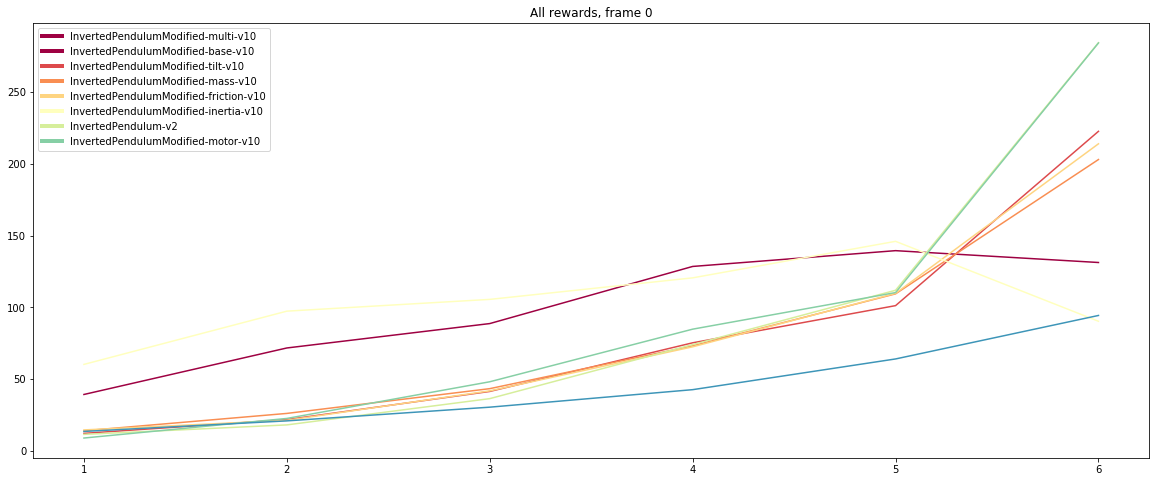

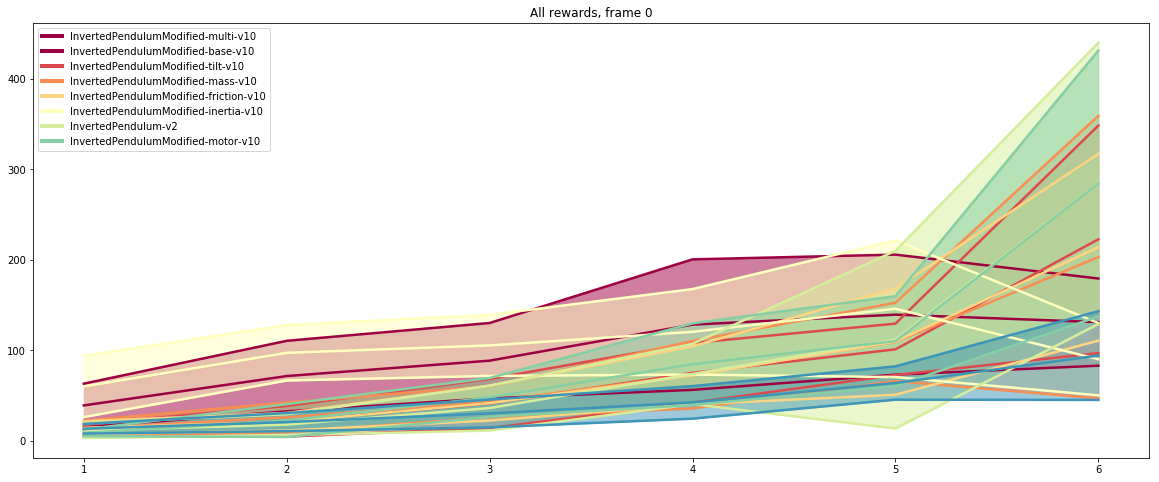

In [ ]:
state = envs.reset()
early_stop = False

while ppo_baseline.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = ppo_baseline.collect_data(envs)
    
    #compute gae
    returns = ppo_baseline.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    ppo_baseline.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []

    for env in tests.envs:
        env_rewards = ([tests.test_env(env, ppo_baseline.model) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)


    if avg_rew[0] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(frame_idx, test_avg_rewards, test_stds, stdplots, rewplots, indvplots, 1)
        early_stop = True
    else:
        tests.plot(frame_idx, test_avg_rewards, test_stds, stdplots, rewplots, indvplots)

ppo_baseline.save_weights(baseline_dir + 'env_name')

## Create compensator environments

In [ ]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
#env_key = "InvertedPendulum-v2" #Unique identifier for custom envs (case sensitive)
env_key = "InvertedPendulum"

env_name = 'InvertedPendulumModified-multi-v10'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'

env_ids = [spec.id for spec in envs.registry.all()]
#test_env_names = [env_name] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
results_dir = os.path.join(script_dir, 'plotting_results/')
baseline_dir = os.path.join(script_dir, 'baseline_weights/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.makedirs(baseline_dir)

tests = testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, logging_interval = 10)


## Train compensator

In [ ]:
class compensator:
    def __init__(self, num_inputs, num_outputs, policy, hidden_size=32, lr = 3e-4, num_steps = 2048,
                 mini_batch_size = 64, ppo_epochs = 10, threshold_reward = 950):
        
        self.ppo_compensator = PPO(num_inputs, num_outputs, hidden_size = hidden_size)
        self.policy = policy
        
    
    def sample_action(self, state):
        #return self.ppo_compensator.model.sample_action(state)
        return self.policy.model.sample_action(state) + self.ppo_compensator.model.sample_action(state)
        
    def collect_data(self, envs):
        if self.ppo_compensator.state is None:
            state = envs.reset()

        #----------------------------------
        #collect data
        #----------------------------------
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        entropy = 0
        counter = 0

        for _ in range(self.ppo_compensator.num_steps):
            
            state = torch.FloatTensor(state).to(device)
            dist, value = self.ppo_compensator.model(state)

            action = dist.sample()
            #action_sum = dist.sample()
            action_sum = dist.sample() + self.policy.model.sample_action(state).detach()
            next_state, reward, done, _ = envs.step(action_sum.cpu().numpy())

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            states.append(state)
            actions.append(action)

            state = next_state
            self.ppo_compensator.frame_idx += 1


        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = self.ppo_compensator.model(next_state)

        return log_probs, values, states, actions, rewards, masks, next_value



In [ ]:
state = envs.reset()
early_stop = False

compensator_test = compensator(num_inputs, num_outputs, ppo_baseline)
test_avg_rewards = []
test_stds = []

while compensator_test.ppo_compensator.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = ppo_baseline.collect_data(envs)
    
    #compute gae
    returns = compensator_test.ppo_compensator.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    compensator_test.ppo_compensator.ppo_update(ppo_epochs, mini_batch_size, 
                                                states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []

    for env in tests.envs:
        env_rewards = ([tests.test_env(env, compensator_test) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)


    if avg_rew[0] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(frame_idx, test_avg_rewards, test_stds, stdplots, rewplots, indvplots, 1)
        early_stop = True
    else:
        tests.plot(frame_idx, test_avg_rewards, test_stds, stdplots, rewplots, indvplots)

ppo_baseline.save_weights(baseline_dir + env_name)